# EDA Lab: Mental Health & Work-Life Balance in the General Social Survey

---

## 1. Description of Data and Motivation

The General Social Survey (GSS) is a nationally representative survey of American adults conducted since 1972. It covers a wide range of topics from demographics to social attitudes to personal well-being. For this analysis, I chose to explore the relationship between **work-life factors and mental well-being**, asking: *How do work demands, financial satisfaction, and demographics relate to happiness and perceived quality of life?*

This topic is relevant because work-life balance has become an increasingly discussed issue, especially after the COVID-19 pandemic shifted many people's relationship with work. Understanding which factors are most strongly associated with happiness can inform both personal decisions and workplace policy.

I selected 13 variables spanning three categories:

**Well-being outcomes:**
- `happy` — General happiness (Very happy / Pretty happy / Not too happy)
- `health` — Self-rated health (Excellent / Good / Fair / Poor)
- `life` — Is life exciting, routine, or dull?

**Work & financial factors:**
- `satjob` — Job satisfaction (Very satisfied to Very dissatisfied)
- `satfin` — Financial satisfaction (Pretty well satisfied / More or less / Not at all)
- `hrs1` — Hours worked per week
- `wrkslf` — Self-employed vs. works for someone else
- `stress` — How often work causes stress
- `realinc` — Inflation-adjusted family income

**Demographics:**
- `age` — Respondent's age
- `sex` — Male or Female
- `educ` — Years of education
- `marital` — Marital status

Together, these variables let us examine how work conditions and financial standing relate to subjective well-being, and whether demographics moderate those relationships.

---
## 2. Loading and Cleaning the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [2]:
raw = pd.read_excel('GSS.xlsx', sheet_name='Data')
print(f"Raw data shape: {raw.shape}")
raw.head()

Raw data shape: (75699, 15)


,year,id_,hrs1,wrkslf,marital,age,educ,sex,happy,health,life,satjob,satfin,stress,realinc
0,1972,1,.i: Inapplicable,Someone else,Never married,23,4 years of college,FEMALE,Not too happy,Good,.i: Inapplicable,A little dissatisfied,Not satisfied at all,.y: Not available in this year,18951.0
1,1972,2,.i: Inapplicable,Someone else,Married,70,10th grade,MALE,Not too happy,Fair,.i: Inapplicable,.i: Inapplicable,More or less satisfied,.i: Inapplicable,24366.0
2,1972,3,.i: Inapplicable,Someone else,Married,48,12th grade,FEMALE,Pretty happy,Excellent,.i: Inapplicable,Moderately satisfied,Pretty well satisfied,.y: Not available in this year,24366.0
3,1972,4,.i: Inapplicable,Someone else,Married,27,5 years of college,FEMALE,Not too happy,Good,.i: Inapplicable,Very satisfied,Not satisfied at all,.y: Not available in this year,30458.0
4,1972,5,.i: Inapplicable,Someone else,Married,61,12th grade,FEMALE,Pretty happy,Good,.i: Inapplicable,.i: Inapplicable,Pretty well satisfied,.y: Not available in this year,50763.0


The GSS uses special codes like `.i: Inapplicable`, `.n: No answer`, `.y: Not available in this year`, etc. for missing data. We need to replace all of these with `NaN` and convert numeric columns appropriately.

In [3]:
df = raw.copy()

# Replace all GSS missing codes with NaN
missing_patterns = ['.i:', '.n:', '.d:', '.y:', '.s:', '.p:', '.m:', '.r:', '.x:', '.f:', '.q:', '.u:']

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'str':
        mask = df[col].astype(str).apply(lambda x: any(x.startswith(p) for p in missing_patterns))
        df.loc[mask, col] = np.nan

# Convert hrs1 and age to numeric
df['hrs1'] = pd.to_numeric(df['hrs1'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Convert educ: text labels like '12th grade', '4 years of college' -> years (0-20)
def parse_educ(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip()
    if val == 'No formal schooling':
        return 0
    # e.g. '12th grade' -> 12, '1st grade' -> 1
    import re
    grade_match = re.match(r'(\d+)(?:st|nd|rd|th)\s+grade', val)
    if grade_match:
        return int(grade_match.group(1))
    # e.g. '4 years of college' -> 12 + 4 = 16, '8 or more years of college' -> 20
    college_match = re.match(r'(\d+)(?:\s+or more)?\s+years?\s+of\s+college', val)
    if college_match:
        return 12 + int(college_match.group(1))
    return np.nan

df['educ'] = df['educ'].apply(parse_educ)

# Drop the id column
df = df.drop(columns=['id_'])

print(f"Cleaned data shape: {df.shape}")
print(f"\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

Cleaned data shape: (75699, 14)

Missing values per column:
stress     59820
hrs1       32671
life       29236
satjob     21568
health     17251
happy       4830
satfin      4686
wrkslf      4165
age         1307
educ         286
sex          131
marital       66
year           0
realinc        0
dtype: int64


Some variables like `stress` and `life` have very high missingness because they were not asked in all survey years. We'll handle this by analyzing each variable with whatever complete cases are available, rather than dropping all incomplete rows (which would lose too much data).

In [4]:
# Create ordinal numeric versions for analysis
# Higher values = "better" for consistency

happy_map = {'Not too happy': 1, 'Pretty happy': 2, 'Very happy': 3}
health_map = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4}
life_map = {'Dull': 1, 'Routine': 2, 'Exciting': 3}
satjob_map = {'Very dissatisfied': 1, 'A little dissatisfied': 2, 'Moderately satisfied': 3, 'Very satisfied': 4}
satfin_map = {'Not satisfied at all': 1, 'More or less satisfied': 2, 'Pretty well satisfied': 3}
stress_map = {'Never': 1, 'Hardly ever': 2, 'Sometimes': 3, 'Often': 4, 'Always': 5}

df['happy_num'] = df['happy'].map(happy_map)
df['health_num'] = df['health'].map(health_map)
df['life_num'] = df['life'].map(life_map)
df['satjob_num'] = df['satjob'].map(satjob_map)
df['satfin_num'] = df['satfin'].map(satfin_map)
df['stress_num'] = df['stress'].map(stress_map)

print("Numeric coding created. Sample:")
df[['happy', 'happy_num', 'health', 'health_num']].dropna().head()

Numeric coding created. Sample:


,happy,happy_num,health,health_num
0,Not too happy,1.0,Good,3.0
1,Not too happy,1.0,Fair,2.0
2,Pretty happy,2.0,Excellent,4.0
3,Not too happy,1.0,Good,3.0
4,Pretty happy,2.0,Good,3.0


---
## 3. Numeric Summaries and Visualizations

### 3.1 Overview of Key Variables

In [5]:
# Summary statistics for numeric variables
num_vars = ['age', 'educ', 'hrs1', 'realinc', 'happy_num', 'health_num', 'satjob_num', 'satfin_num']
df[num_vars].describe().round(2)

,age,educ,hrs1,realinc,happy_num,health_num,satjob_num,satfin_num
count,74392.00,75413.00,43028.00,75699.00,70869.00,58448.00,54131.00,71013.00
mean,46.47,13.09,40.78,29148.56,2.15,2.97,3.29,2.02
std,17.38,3.18,13.59,30510.15,0.64,0.83,0.81,0.75
min,18.00,0.00,0.00,-100.00,1.00,1.00,1.00,1.00
25%,32.00,12.00,37.00,8308.00,2.00,2.00,3.00,1.00
50%,44.00,13.00,40.00,21285.00,2.00,3.00,3.00,2.00
75%,60.00,16.00,48.00,38373.75,3.00,4.00,4.00,3.00
max,88.00,20.00,88.00,162607.00,3.00,4.00,4.00,3.00


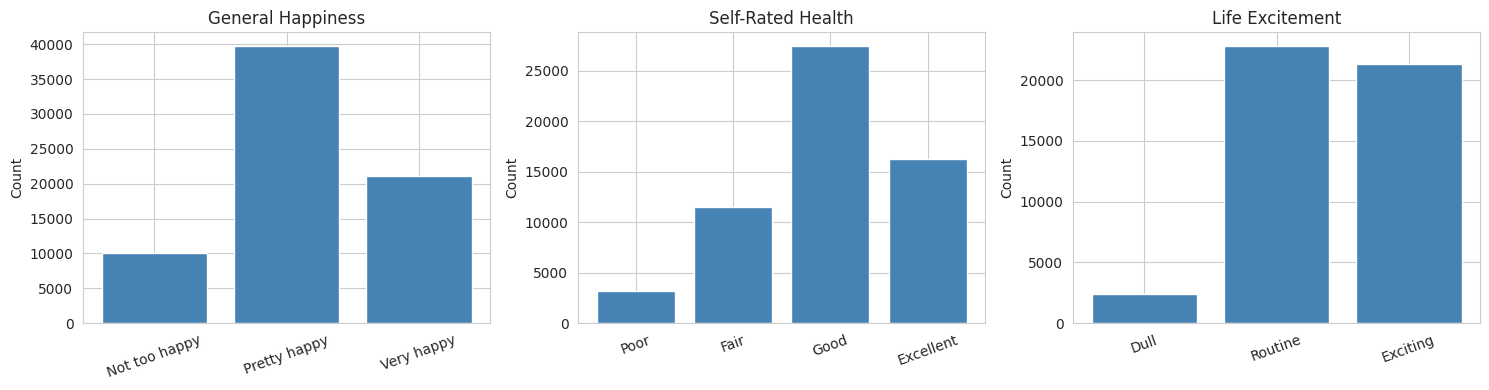

In [6]:
# Distribution of happiness, health, and life excitement
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col, title in zip(axes, ['happy', 'health', 'life'],
                           ['General Happiness', 'Self-Rated Health', 'Life Excitement']):
    counts = df[col].dropna().value_counts()
    if col == 'happy':
        order = ['Not too happy', 'Pretty happy', 'Very happy']
    elif col == 'health':
        order = ['Poor', 'Fair', 'Good', 'Excellent']
    else:
        order = ['Dull', 'Routine', 'Exciting']
    counts = counts.reindex(order)
    ax.bar(counts.index, counts.values, color='steelblue', edgecolor='white')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=20)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

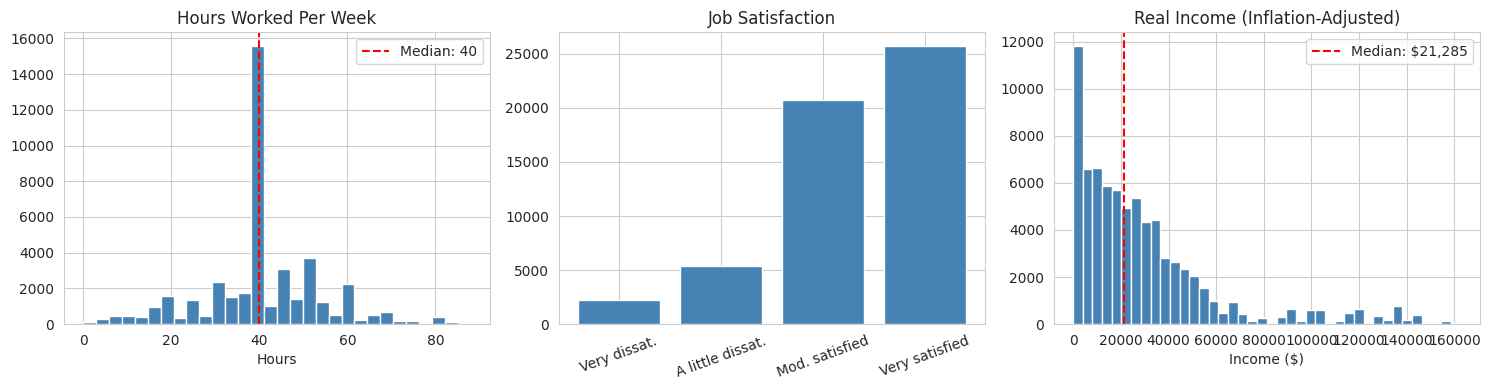

In [7]:
# Distribution of work variables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Hours worked
df['hrs1'].dropna().hist(bins=30, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Hours Worked Per Week')
axes[0].set_xlabel('Hours')
axes[0].axvline(df['hrs1'].median(), color='red', linestyle='--', label=f"Median: {df['hrs1'].median():.0f}")
axes[0].legend()

# Job satisfaction
order_sj = ['Very dissatisfied', 'A little dissatisfied', 'Moderately satisfied', 'Very satisfied']
counts_sj = df['satjob'].dropna().value_counts().reindex(order_sj)
axes[1].bar(range(len(order_sj)), counts_sj.values, color='steelblue', edgecolor='white')
axes[1].set_xticks(range(len(order_sj)))
axes[1].set_xticklabels(['Very dissat.', 'A little dissat.', 'Mod. satisfied', 'Very satisfied'], rotation=20)
axes[1].set_title('Job Satisfaction')

# Income
df['realinc'].dropna().hist(bins=40, ax=axes[2], color='steelblue', edgecolor='white')
axes[2].set_title('Real Income (Inflation-Adjusted)')
axes[2].set_xlabel('Income ($)')
axes[2].axvline(df['realinc'].median(), color='red', linestyle='--', label=f"Median: ${df['realinc'].median():,.0f}")
axes[2].legend()

plt.tight_layout()
plt.show()

### 3.2 Relationships Between Work Factors and Happiness

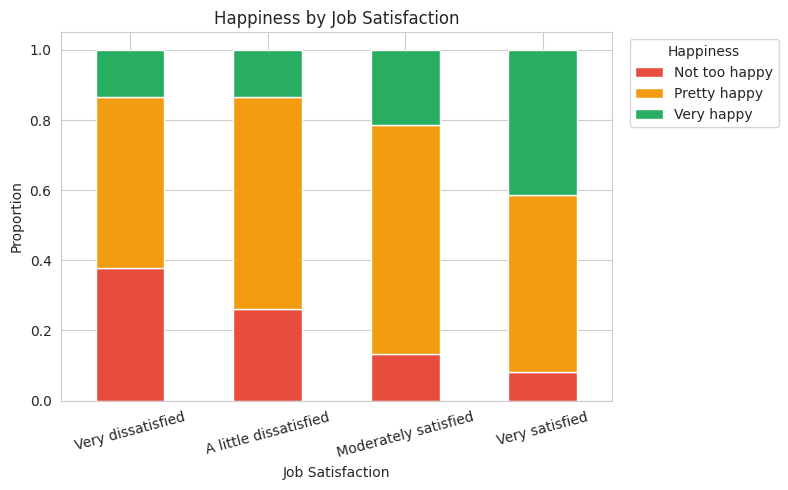

Proportion table:
happy                  Not too happy  Pretty happy  Very happy
satjob                                                        
Very dissatisfied              0.379         0.486       0.134
A little dissatisfied          0.260         0.605       0.135
Moderately satisfied           0.134         0.650       0.216
Very satisfied                 0.081         0.504       0.415


In [8]:
# Happiness by job satisfaction
ct = pd.crosstab(df['satjob'], df['happy'], normalize='index').reindex(
    index=['Very dissatisfied', 'A little dissatisfied', 'Moderately satisfied', 'Very satisfied'],
    columns=['Not too happy', 'Pretty happy', 'Very happy']
)

ct.plot(kind='bar', stacked=True, figsize=(8, 5), 
        color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='white')
plt.title('Happiness by Job Satisfaction')
plt.ylabel('Proportion')
plt.xlabel('Job Satisfaction')
plt.xticks(rotation=15)
plt.legend(title='Happiness', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

print("Proportion table:")
print(ct.round(3))

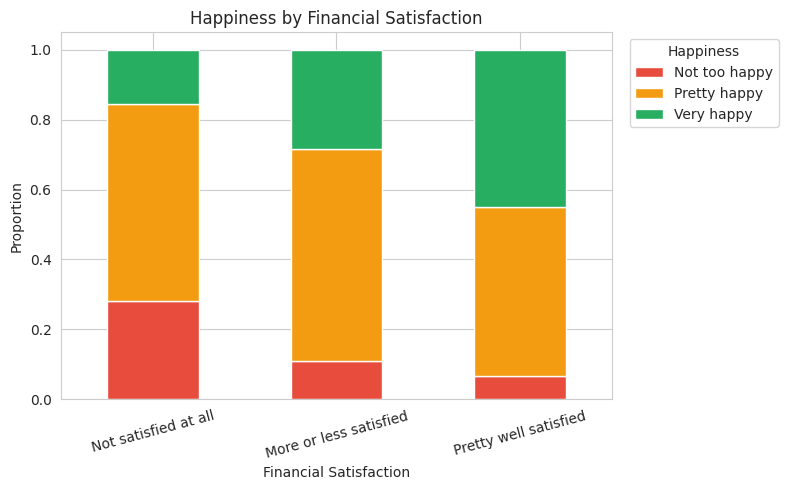

In [9]:
# Happiness by financial satisfaction
ct2 = pd.crosstab(df['satfin'], df['happy'], normalize='index').reindex(
    index=['Not satisfied at all', 'More or less satisfied', 'Pretty well satisfied'],
    columns=['Not too happy', 'Pretty happy', 'Very happy']
)

ct2.plot(kind='bar', stacked=True, figsize=(8, 5),
         color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='white')
plt.title('Happiness by Financial Satisfaction')
plt.ylabel('Proportion')
plt.xlabel('Financial Satisfaction')
plt.xticks(rotation=15)
plt.legend(title='Happiness', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

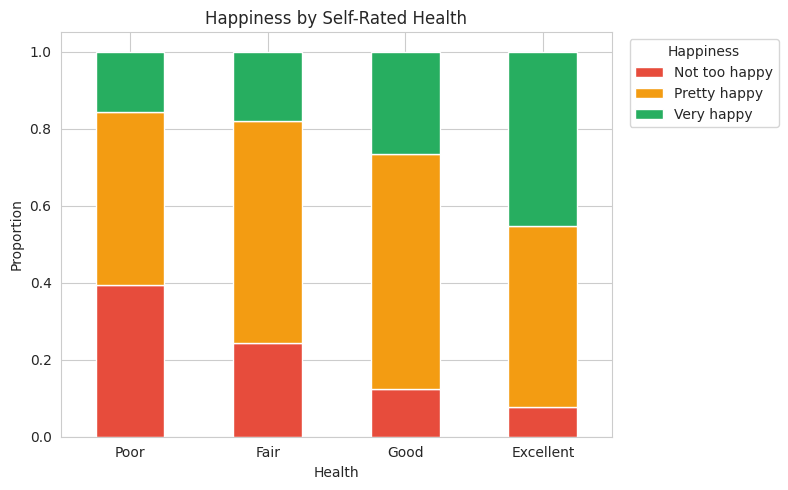

In [10]:
# Happiness by self-rated health
ct3 = pd.crosstab(df['health'], df['happy'], normalize='index').reindex(
    index=['Poor', 'Fair', 'Good', 'Excellent'],
    columns=['Not too happy', 'Pretty happy', 'Very happy']
)

ct3.plot(kind='bar', stacked=True, figsize=(8, 5),
         color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='white')
plt.title('Happiness by Self-Rated Health')
plt.ylabel('Proportion')
plt.xlabel('Health')
plt.xticks(rotation=0)
plt.legend(title='Happiness', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

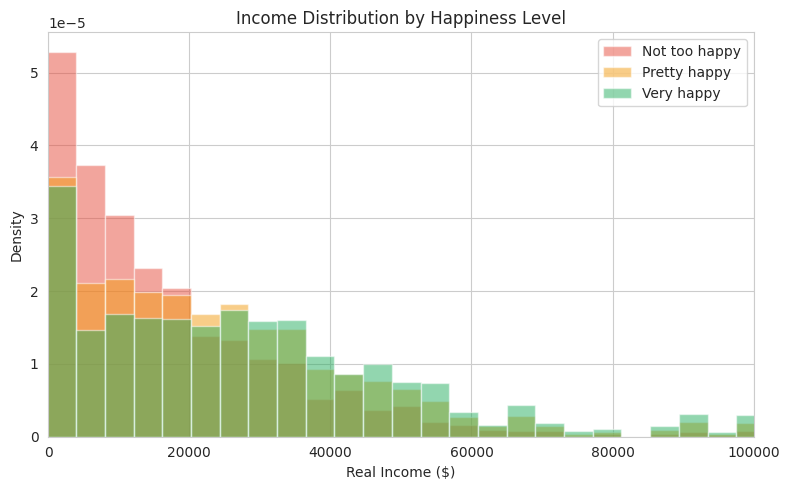

Median income by happiness:
happy
Not too happy    $12,520
Pretty happy     $21,299
Very happy       $26,015
Name: realinc, dtype: str


In [11]:
# Income distribution by happiness level
fig, ax = plt.subplots(figsize=(8, 5))
for label, color in zip(['Not too happy', 'Pretty happy', 'Very happy'], ['#e74c3c', '#f39c12', '#27ae60']):
    subset = df.loc[df['happy'] == label, 'realinc'].dropna()
    ax.hist(subset, bins=40, alpha=0.5, label=label, color=color, density=True)

ax.set_title('Income Distribution by Happiness Level')
ax.set_xlabel('Real Income ($)')
ax.set_ylabel('Density')
ax.legend()
ax.set_xlim(0, 100000)
plt.tight_layout()
plt.show()

print("Median income by happiness:")
print(df.groupby('happy')['realinc'].median().reindex(['Not too happy', 'Pretty happy', 'Very happy']).apply(lambda x: f"${x:,.0f}"))

### 3.3 Demographic Patterns

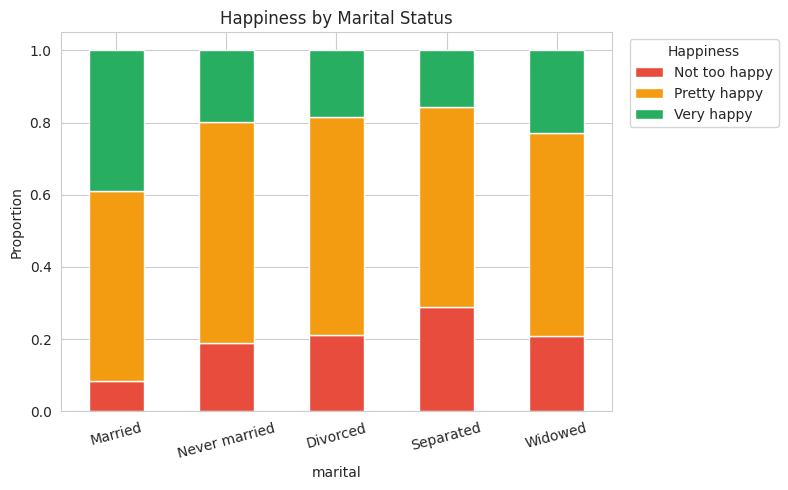

In [12]:
# Happiness by marital status
marital_order = ['Married', 'Never married', 'Divorced', 'Separated', 'Widowed']
ct4 = pd.crosstab(df['marital'], df['happy'], normalize='index').reindex(
    index=marital_order,
    columns=['Not too happy', 'Pretty happy', 'Very happy']
)

ct4.plot(kind='bar', stacked=True, figsize=(8, 5),
         color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='white')
plt.title('Happiness by Marital Status')
plt.ylabel('Proportion')
plt.xticks(rotation=15)
plt.legend(title='Happiness', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

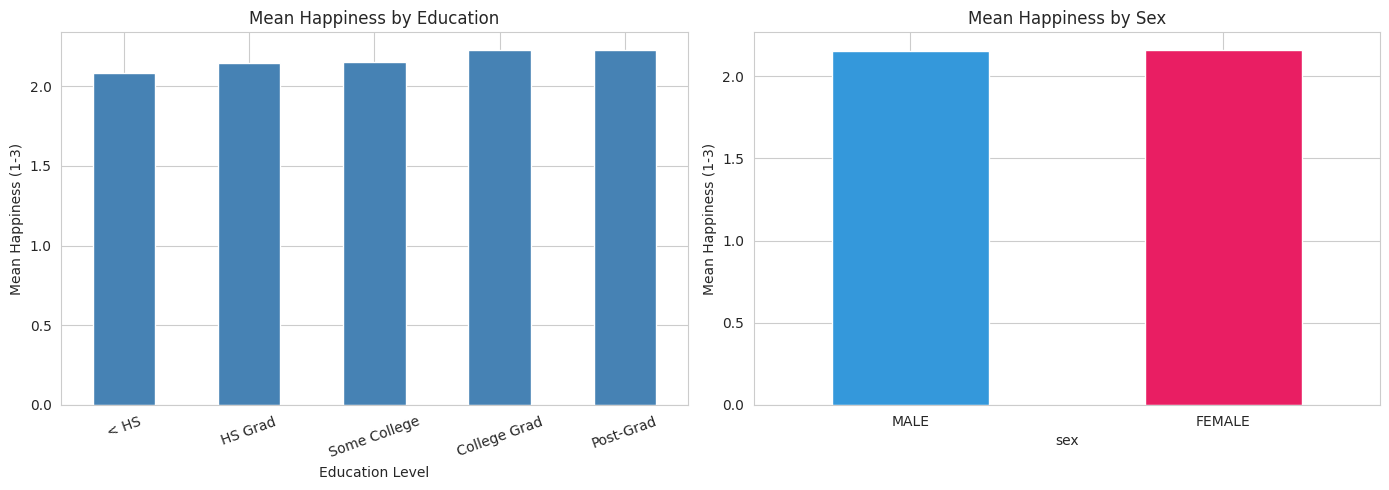

In [13]:
# Mean happiness by education level and sex
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Happiness by education (binned)
df['educ_bin'] = pd.cut(df['educ'], bins=[0, 11, 12, 15, 16, 20], 
                         labels=['< HS', 'HS Grad', 'Some College', 'College Grad', 'Post-Grad'])
educ_happy = df.groupby('educ_bin', observed=True)['happy_num'].mean()
educ_happy.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Mean Happiness by Education')
axes[0].set_ylabel('Mean Happiness (1-3)')
axes[0].set_xlabel('Education Level')
axes[0].tick_params(axis='x', rotation=20)

# Happiness by sex
sex_happy = df.groupby('sex')['happy_num'].mean().reindex(['MALE', 'FEMALE'])
sex_happy.plot(kind='bar', ax=axes[1], color=['#3498db', '#e91e63'], edgecolor='white')
axes[1].set_title('Mean Happiness by Sex')
axes[1].set_ylabel('Mean Happiness (1-3)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

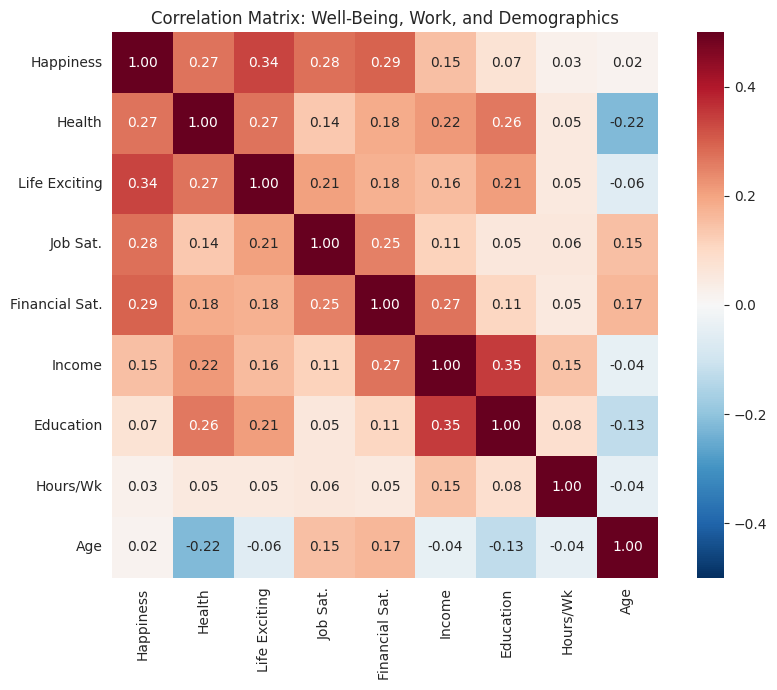

In [14]:
# Correlation heatmap among numeric variables
corr_vars = ['happy_num', 'health_num', 'life_num', 'satjob_num', 'satfin_num', 'realinc', 'educ', 'hrs1', 'age']
corr_labels = ['Happiness', 'Health', 'Life Exciting', 'Job Sat.', 'Financial Sat.', 'Income', 'Education', 'Hours/Wk', 'Age']

corr_matrix = df[corr_vars].corr()
corr_matrix.index = corr_labels
corr_matrix.columns = corr_labels

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-0.5, vmax=0.5, ax=ax, square=True)
ax.set_title('Correlation Matrix: Well-Being, Work, and Demographics')
plt.tight_layout()
plt.show()

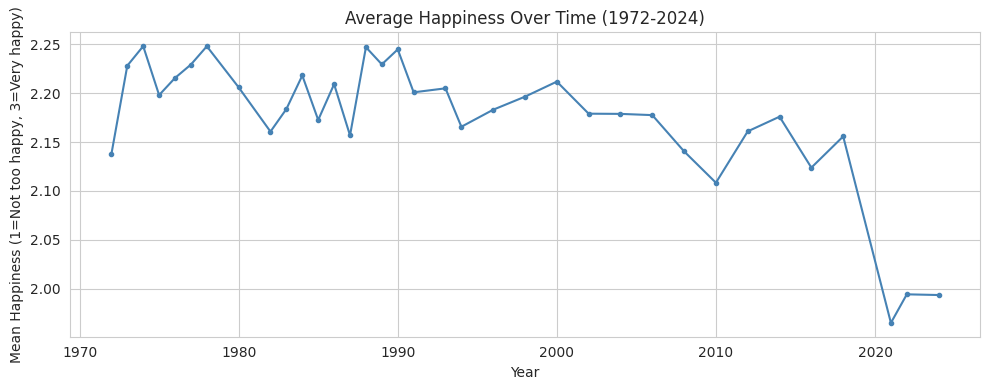

In [15]:
# Happiness trend over time
trend = df.groupby('year')['happy_num'].mean().dropna()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(trend.index, trend.values, marker='o', markersize=3, color='steelblue')
ax.set_title('Average Happiness Over Time (1972-2024)')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Happiness (1=Not too happy, 3=Very happy)')
plt.tight_layout()
plt.show()

---
## 4. Findings

### Key Finding 1: Job and Financial Satisfaction Are Strongly Tied to Happiness

The stacked bar charts reveal a clear gradient: among people who are "very satisfied" with their jobs, a large proportion report being "very happy," while among the "very dissatisfied," unhappiness rates are dramatically higher. The same pattern holds for financial satisfaction — those who feel financially secure are much more likely to report being very happy. This is consistent with decades of well-being research showing that perceived financial adequacy matters more than raw income.

### Key Finding 2: Health Is One of the Strongest Correlates of Happiness

Self-rated health shows one of the clearest relationships with happiness. Among those reporting "excellent" health, the majority are "very happy," while among those in "poor" health, nearly half report being "not too happy." The correlation matrix confirms that health and happiness have one of the strongest pairwise correlations in the dataset. This highlights how central physical well-being is to overall life satisfaction.

### Key Finding 3: Income Matters, But With Diminishing Returns

The income distributions by happiness level show that "very happy" people tend to have higher incomes, with a clear separation in medians across groups. However, the overlap between the distributions is substantial, suggesting that income alone is a weak predictor. The correlation between income and happiness, while positive, is modest compared to health or job satisfaction. Money helps, but it's far from the whole story.

### Key Finding 4: Marriage Is Associated With Greater Happiness

Married respondents consistently report the highest happiness levels, while separated individuals report the lowest. This is one of the most robust findings in the happiness literature and is clearly replicated here. Widowed and divorced respondents fall in between, though divorced individuals report higher unhappiness than those who never married.

### Key Finding 5: Happiness Has Been Remarkably Stable Over 50 Years

Despite massive social, economic, and technological changes since 1972, average happiness has remained largely flat, hovering around "pretty happy" with only modest fluctuations. There may be a slight dip in the most recent years, which could reflect pandemic-related disruptions, but the overall stability is striking and consistent with the "hedonic treadmill" theory — the idea that people adapt to changing circumstances and return to a baseline level of happiness.

### Key Finding 6: Education and Hours Worked Have Weak Direct Links to Happiness

The correlation matrix shows that education and weekly hours worked have only weak correlations with happiness. Education's effect on happiness likely operates indirectly through income and job quality rather than directly. Hours worked show almost no relationship with happiness, suggesting that it's not how much you work but how you feel about your work that matters.

### Conclusion

This analysis suggests that subjective perceptions — how people feel about their health, their job, and their finances — are far more important predictors of happiness than objective measures like income, education, or hours worked. The strongest correlates of happiness are health, job satisfaction, financial satisfaction, and marital status. These findings are consistent across over 50 years of GSS data and align with the broader psychological literature on subjective well-being. For anyone seeking greater happiness, the data suggest that investing in health, finding meaningful work, and building strong relationships may matter more than maximizing income or credentials.